# Решающие деревья

In [94]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
from tqdm.notebook import tqdm, tnrange
from math import sqrt
from sklearn.model_selection import train_test_split
from collections import Counter

## Подготовка данных

In [2]:
data_dirname = 'DT_csv/'

In [3]:
num_data = int(len(os.listdir(data_dirname))/2)

In [4]:
def read_csv_by_number(num):
    name_train = data_dirname + str(num).zfill(2) + '_train.csv'
    name_test = data_dirname + str(num).zfill(2) + '_test.csv'
    
    df_train = pd.read_csv(name_train)
    df_test = pd.read_csv(name_test)
    
    arr_train = df_train.to_numpy()
    arr_test = df_test.to_numpy()
    
    return arr_train[:, :-1], arr_train[:, -1], arr_test[:, :-1], arr_test[:, -1]

In [5]:
X_train = []
Y_train = []
X_test = []
Y_test = []

for i in range(1, num_data + 1):
    x_train, y_train, x_test, y_test = read_csv_by_number(i)
    X_train.append(x_train)
    Y_train.append(y_train)
    X_test.append(x_test)
    Y_test.append(y_test)

## Поиск оптимальной высоты решающего дерева

Как работает алгоритм построение бинарного решающего дерева?
- если выполнен критерий останова, то находим прогноз в этой вершине и объявляем вершины листовой
- находим наилучшее разбиение на две части $R_1(j, t) = \{x \mid x_j < t\}$ и $R_2(j, t) = \{x \mid x_j \geq t\}$ с точки зрения заранее заданного функционала качества $Q(X, j, t)$, который равен $Q(R_m, j, s)= H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r)$, где $H(R)$ &mdash; impurity criterion
    - по факту $H(R)$ &mdash; критерия разнообразия ответов в этом множестве, критерий того, насколько эта вершина похожа на листовую уже
    - чем меньше $H(R)$, тем лучше $\implies$ чем больше $Q(R_m, j, s)$, тем лучше
- найдя наилучшие значения $j$ и $t$, создадим корневую вершину дерева, поставив ей в соответствие предикат $[x_j < t]$
- объекты разобьются на две части &mdash; одни попадут в левое поддерево, другие в правое, для каждой из этих подвыборок рекурсивно повторим процедуру

Перебирая гиперпараметры и возможные значения глубины, находим параметры для максимальной `accuracy`.

In [6]:
criterions = {"gini", "entropy"}
splitters = {"best", "random"}
max_depth = 30

In [7]:
def get_dt(criterion, splitter, depth):
    clf = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=depth)
    return clf

In [8]:
def find_hyper_params_with_optimal_depth(x_train, y_train, x_test, y_test):
    max_accuracy = 0
    best_params = []
    
    with tqdm(total=len(criterions)*len(splitters)*max_depth, desc="treeprogress", leave=False, colour='green') as trp:
        for cr in criterions:
            for spl in splitters:
                for d in range(1, max_depth+1):
                    clf = get_dt(cr, spl, d)
                    clf = clf.fit(x_train, y_train)

                    y_pred = clf.predict(x_test)
                    accuracy = accuracy_score(y_test, y_pred)
                    depth = clf.get_depth()

                    if (accuracy > max_accuracy):
                        max_accuracy = accuracy
                        best_params = [depth, accuracy, spl, cr]

                    trp.update(1)

    return best_params

In [10]:
min_opt_depth = 100000
max_opt_depth = 0

min_params = []
max_params = []

for i in tnrange(num_data, desc='total'):

    params = find_hyper_params_with_optimal_depth(X_train[i], Y_train[i], X_test[i], Y_test[i])
    print('#' + str(i+1) + ': ' + str(params))
    
    if (params[0] < min_opt_depth):
        min_opt_depth = params[0]
        min_params = [i] + params
    if (params[0] > max_opt_depth):
        max_opt_depth = params[0]
        max_params = [i] + params

#1: [3, 0.9997429966589566, 'best', 'entropy']


#2: [10, 0.6982188295165395, 'best', 'entropy']


#3: [1, 1.0, 'best', 'gini']


#4: [5, 0.9951304347826087, 'best', 'entropy']


#5: [5, 0.9978354978354979, 'random', 'gini']


#6: [3, 0.9988962472406181, 'best', 'entropy']


#7: [3, 0.9967441860465116, 'best', 'entropy']


#8: [2, 0.997920997920998, 'best', 'gini']


#9: [5, 0.8529411764705882, 'best', 'entropy']


#10: [4, 0.9979879275653923, 'best', 'entropy']


#11: [1, 0.999195171026157, 'best', 'gini']


#12: [10, 0.8762278978388998, 'best', 'entropy']


#13: [7, 0.6568807339449542, 'best', 'entropy']


#14: [5, 0.990351215746816, 'best', 'entropy']


#15: [1, 1.0, 'best', 'gini']


#16: [1, 1.0, 'best', 'gini']


#17: [7, 0.8503629257398102, 'best', 'entropy']


#18: [5, 0.9426656738644825, 'best', 'entropy']


#19: [7, 0.8334583645911477, 'best', 'entropy']


#20: [7, 0.9690966719492868, 'best', 'entropy']


#21: [13, 0.8123018389346861, 'best', 'entropy']



### Зависимость accuracy от глубины

In [19]:
def get_all_accs_for_hyper_params(x_train, y_train, x_test, y_test, criterion, splitter):

    accs_train = []
    accs_test = []
    depths = []
    
    with tqdm(total=max_depth, desc="treeprogress", leave=True, colour='green') as trp:
        for d in range(1, max_depth+1):
            clf = get_dt(criterion, splitter, d)
            clf = clf.fit(x_train, y_train)

            y_pred_train = clf.predict(x_train)
            accuracy_train = accuracy_score(y_train, y_pred_train)
            y_pred_test = clf.predict(x_test)
            accuracy_test = accuracy_score(y_test, y_pred_test)

            accs_train.append(accuracy_train)
            accs_test.append(accuracy_test)
            depths.append(d)

            trp.update(1)

    return accs_train, accs_test

In [13]:
depths = [i for i in range(1, max_depth+1)]

### График для минималов

In [14]:
min_idx = min_params[0]
min_spl = min_params[3]
min_cr = min_params[4]

In [20]:
min_accs_train, min_accs_test = get_all_accs_for_hyper_params(X_train[min_idx], Y_train[min_idx], X_test[min_idx], Y_test[min_idx], min_cr, min_spl)

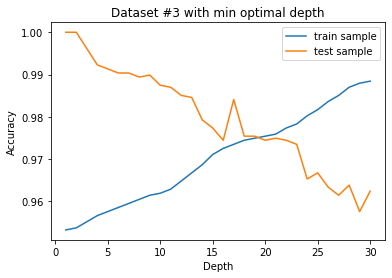

In [39]:
plt.plot(depths, min_accs_train, label="train sample")
plt.plot(depths, min_accs_test, label="test sample")
plt.title("Dataset #" + str(min_idx+1) + " with min optimal depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

### График для максималов

In [30]:
max_idx = max_params[0]
max_spl = max_params[3]
max_cr = max_params[4]

In [32]:
max_accs_train, max_accs_test = get_all_accs_for_hyper_params(X_train[max_idx], Y_train[max_idx], X_test[max_idx], Y_test[max_idx], max_cr, max_spl)

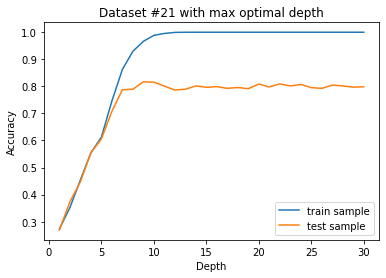

In [41]:
plt.plot(depths, max_accs_train, label="train sample")
plt.plot(depths, max_accs_test, label="test sample")
plt.title("Dataset #" + str(max_idx+1) + " with max optimal depth")
plt.xlabel("Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Случайный лес 

Мы хотим с помощью бэггинга построить хорошую композицию. \
Хорошая композиция: низкое смещение + низкая ковариация. \
Низкое смещение: глубокие деревья. \
Низкая ковариация: 
- бутстрап
- обучаться на подвыборке признаков (плохо! если хороший признак не попадет в подвыборку, то будет сильное смещение)
- на каждом листочке выбираем рандомно m признаков, на которых будем обучаться

In [114]:
def random_forest(x_train, y_train, x_test, y_test):
    
    preds_train = []
    preds_test = []
    mfeatures = len(x_train[0])
    
    with tqdm(total=len(criterions)*len(splitters)*min(20, mfeatures-sqrt(mfeatures))*10, desc="forestprogress", leave=False, colour='green') as trp:
        for i in range(10):
            
            x_train_sample, _, y_train_sample, _ = train_test_split(x_train, y_train, test_size = 0.2)
            
            for cr in criterions:
                for spl in splitters:
                    for m in range(int(sqrt(mfeatures)), min(int(sqrt(mfeatures))+20, mfeatures)):
                        clf = DecisionTreeClassifier(criterion=cr, splitter=spl, max_features=m)
                        clf = clf.fit(x_train_sample, y_train_sample)

                        y_pred_train = clf.predict(x_train)
                        y_pred_test = clf.predict(x_test)

                        preds_train.append(y_pred_train)
                        preds_test.append(y_pred_test)

                        trp.update(1)
    
    final_preds_train = [Counter(y_pred[i] for y_pred in preds_train).most_common(1)[0][0] for i in range(len(y_train))]
    final_preds_test = [Counter(y_pred[i] for y_pred in preds_test).most_common(1)[0][0] for i in range(len(y_test))]

    
    return [accuracy_score(final_preds_train, y_train), accuracy_score(final_preds_test, y_test)]

In [115]:
for i in tnrange(num_data, desc='total'):

    accs = random_forest(X_train[i], Y_train[i], X_test[i], Y_test[i])
    
    print('#' + str(i+1) + ': ' + str(accs))

#1: [0.9997429966589566, 0.9997429966589566]


#2: [1.0, 0.6315521628498728]


#3: [1.0, 0.9995178399228544]


#4: [1.0, 0.9471304347826087]


#5: [1.0, 0.9978354978354979]


#6: [0.9994481236203091, 0.9994481236203091]


#7: [1.0, 0.9804651162790697]


#8: [1.0, 0.9708939708939709]


#9: [1.0, 0.8274509803921568]


#10: [0.9995975855130784, 0.9987927565392354]


#11: [0.999195171026157, 0.999195171026157]


#12: [1.0, 0.9138366545046309]


#13: [1.0, 0.6403669724770642]


#14: [1.0, 0.9691238903898108]


#15: [0.9993993993993994, 0.9993993993993994]


#16: [1.0, 1.0]


#17: [1.0, 0.7437185929648241]


#18: [1.0, 0.8562918838421445]


#19: [1.0, 0.8514628657164292]


#20: [0.9996038034865293, 0.9837559429477021]


#21: [1.0, 0.8604946100190235]

